# TODO

Intro
- EDA (correlation matrix) ; fouskakis 
Dataset
- add more columns from codebook 
Features
- bmi, weight, height, bmi_group -> avoid multicollinearity
- scaler to columns: height, weight, bmi
- correlation matrix to drop highly correlated features, threshold = 0.75
- feature importance analysis / 
- one hot encoding to categorical columns
Balance data
- explore ways to balance data
- SMOTE
Code
- confusion matrix to function
- superclass classifier
Model
- explore classifiers
- grid search -> find best 
- model explainability
Extra
- further research -> kaggle notebooks
- counterfactual explanations

## Finish xgb and logistic regression classes


Links<br>
https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators<br>
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset<br>
https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf<br>
https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system/data<br>
https://www.cdc.gov/pcd/issues/2019/19_0109.htm<br>
https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook<br>

# Info

- Έγιναν drop columns που αφορούσαν ερωτήσεις σε άτομα που ήδη έχουν διαβήτη, καθώς και η στήλη prediabetes.
- Αφαιρέθηκαν τα rows με διαβήτη τύπου 1, ο οποίο είναι αυτοάνοσο νόσημα.
0: no diabetes, or only during pregnancy<br>
1: prediabetes<br>
2: diabetes

# Imports

In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import xgboost

In [2]:
path = 'Data/'
RAND_STATE = 42

In [3]:
inputs = pd.read_csv(path + 'diabetes_dataset.csv')

# EDA

In [4]:
def plot_correlation_matrix(data):
    
    corr_matrix = data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title('Feature Correlation Matrix')
    plt.show()

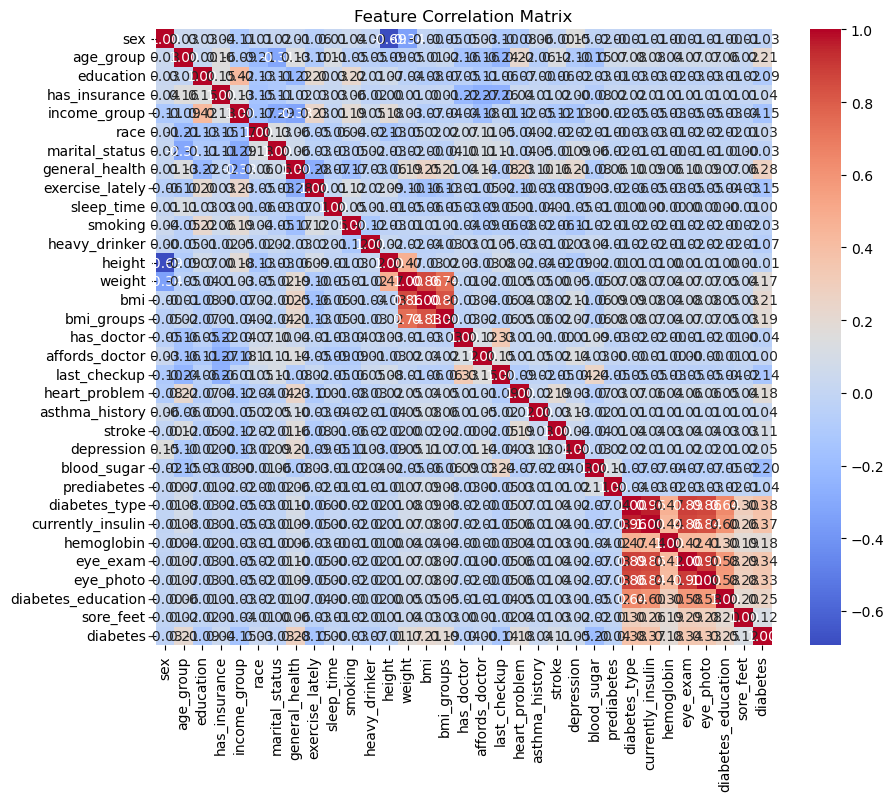

In [5]:
plot_correlation_matrix(inputs)

# Preprocessing

## Functions

In [6]:
class preprocessing():
    
    def __init__(self, raw):
        self.data = raw.copy()
        self.label_name = 'diabetes'
        
    def convert_type(self):
        for col in self.data:
            self.data[col] = self.data[col].astype(int)
            
    def extract_labels(self):
        self.labels = self.data[[self.label_name]].to_numpy().flatten()
        
    def class_frequencies(self):
        _ , self.class_samples = np.unique(self.labels, return_counts=True)
        self.class_freq = self.class_samples/len(self.data)
#         if as_pct==True:
#             print(self.class_freq)
#         else:
#             print(self.class_samples)
    
    def remove_labels(self):
        self.data.drop([self.label_name], axis=1, inplace=True)
    
    def resample(self, T, num_samples):
        # using Rare Class Sampling
        self.extract_labels()
        self.class_frequencies() 
        probs = np.exp((1 - self.class_freq) / T)
        probs /= probs.sum()
        self.data['sample_weight'] = self.data[self.label_name].map({0: probs[0], 1: probs[1], 2: probs[2]})
        self.data = self.data.sample(n=num_samples, replace=False, weights='sample_weight', random_state=RAND_STATE)
        self.data.drop(['sample_weight'], axis=1, inplace=True)
        
    def remove_cols(self, cols_to_drop):
        self.data.drop(cols_to_drop, axis=1, inplace=True)
        
    def equalize(self):
        tmp1 = self.data[self.data[self.label_name]==0].sample(n=4631, replace=False, random_state=RAND_STATE)
        tmp2 = self.data[self.data[self.label_name]==1].sample(n=4631, replace=False, random_state=RAND_STATE)
        tmp3 = self.data[self.data[self.label_name]==2].sample(n=4631, replace=False, random_state=RAND_STATE)
        self.data = pd.concat([tmp1, tmp2, tmp3]).sample(frac=1, random_state = RAND_STATE)


## Pipeline

In [7]:
def preprocessing_pipeline(resample, equalize=False, T=0.1, n_samples=50000):
    obj = preprocessing(inputs)
    
    # drop diabetes type1
    obj.data = obj.data[obj.data['diabetes_type']!=1] 
    
    drop_cols = ['diabetes_type',
             'currently_insulin',
             'hemoglobin',
             'eye_exam',
             'eye_photo',
             'diabetes_education',
             'sore_feet',
             'prediabetes']

    obj.remove_cols(drop_cols)
#     obj.convert_type()
    if resample:
        obj.resample(T, n_samples)
    if equalize:
        obj.equalize()    
    obj.extract_labels()
    obj.class_frequencies()
    obj.remove_labels()
    
    
    return obj

## Create dataframes

In [8]:
without_resampling = preprocessing_pipeline(resample=False)

In [9]:
with_resampling = preprocessing_pipeline(resample=True, T=0.1, n_samples=50000)

In [10]:
equalized = preprocessing_pipeline(resample=False, equalize = True)

# Model training

## Training pipeline

In [11]:
def training_pipeline(classifier, report=False, fi=False, cm=False):
    classifier.create_model()
    classifier.split(test_size=0.2)
    classifier.train()
    if report:
        classifier.generate_classification_report()
    if fi:
        classifier.feature_importance()
    if cm:
        classifier.plot_confusion_matrix()

## Base Classifier

In [12]:
class BaseClassifier:
    def __init__(self, data, labels, random_state=42):
        self.random_state = random_state
        self.data = data
        self.labels = labels
        self.model = None

    def create_model(self):
        # Placeholder for model creation
        raise NotImplementedError("This method should be overridden by subclasses")

    def split(self, test_size=0.2, stratify=True):
        stratify_labels = self.labels if stratify else None
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(
            self.data, 
            self.labels,
            test_size=test_size,
            random_state=self.random_state,
            stratify=stratify_labels 
        )

    def train(self):
        if self.model is not None:
            self.model.fit(self.train_data, self.train_labels)

    def generate_classification_report(self):
#         if self.model is not None:
        predictions = self.model.predict(self.test_data)
        print(classification_report(self.test_labels, predictions))

    def plot_confusion_matrix(self):
#         if self.model is not None:
        y_pred = self.model.predict(self.test_data)
        cm = confusion_matrix(self.test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()


## Random forest class

In [13]:
class random_forest(BaseClassifier):
    
    def create_model(self):
        self.model = RandomForestClassifier(random_state=self.random_state)

    def feature_importance(self):
        if self.model is not None:
            importance = self.model.feature_importances_
            features = self.train_data.columns

            indices = np.argsort(importance)
            sorted_importance = np.take(importance, indices, axis=0)
            sorted_features = np.take(features, indices, axis=0)

            plt.figure(figsize=(6, 6))
            plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
            plt.yticks(range(len(sorted_importance)), sorted_features)
            plt.xlabel('Feature Importance')
            plt.ylabel('Feature')
            plt.show()


## XGBoost class

In [ ]:
class xgb:
    def __init__(self, data, labels):
        self.random_state = 42
        self.model = xgboost.XGBClassifier(objective="multi:softprob", random_state=self.random_state)
        self.data = data
        self.labels = labels
        
    def split(self, test_size=0.2, stratify=True):
        stratify_labels = self.labels if stratify else None
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(
            self.data, 
            self.labels,
            test_size=test_size,
            random_state=self.random_state,
            stratify=stratify_labels 
        )
        
    def train(self):
        self.model.fit(self.train_data, self.train_labels)

    def score(self):
        return self.model.score(self.test_data, self.test_labels)
        
    def generate_classification_report(self):
        predictions = self.predict()
        print(classification_report(self.test_labels, predictions))
        
    def feature_importance(self):
        importance = self.model.feature_importances_
        features   = self.train_data.columns

        indices = np.argsort(importance)
        sorted_importance = np.take(importance, indices, axis=0)
        sorted_features    = np.take(features, indices, axis=0)

        plt.figure(figsize=(6, 6))
        plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
        plt.yticks(range(len(sorted_importance)), sorted_features) 
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
    #     plt.title('Feature Importances')
        plt.show()
        
    def plot_confusion_matrix(self):
        y_true = self.test_labels
        y_pred = self.predict(self.test_data)
        cm = confusion_matrix(y_true, y_pred, labels = [0, 1, 2])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non diabetics', 'Prediabetics', 'Diabetics'])
        disp.plot(cmap=plt.cm.Blues)
        plt.show() 

## Logistic Regression class

In [ ]:
class logistic_regression:
    def __init__(self, data, labels):
        self.random_state = 42
        self.model = LogisticRegression(random_state=self.random_state)
        self.data = data
        self.labels = labels
        
    def split(self, test_size=0.2, stratify=True):
        stratify_labels = self.labels if stratify else None
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(
            self.data, 
            self.labels,
            test_size=test_size,
            random_state=self.random_state,
            stratify=stratify_labels 
        )
        
    def train(self):
        self.model.fit(self.train_data, self.train_labels)
        
    def predict(self):
        return self.model.predict(self.test_data)

    def score(self):
        return self.model.score(self.test_data, self.test_labels)
        
    def generate_classification_report(self):
        predictions = self.predict()
        print(classification_report(self.test_labels, predictions))
        
    def feature_importance(self):
        importance = self.model.feature_importances_
        features   = self.train_data.columns

        indices = np.argsort(importance)
        sorted_importance = np.take(importance, indices, axis=0)
        sorted_features    = np.take(features, indices, axis=0)

        plt.figure(figsize=(6, 6))
        plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
        plt.yticks(range(len(sorted_importance)), sorted_features)  # Assuming 'features' is a list of feature names
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
    #     plt.title('Feature Importances')
        plt.show()
        
    def plot_confusion_matrix(self):
        y_true = self.test_labels
        y_pred = self.predict(self.test_data)
        cm = confusion_matrix(y_true, y_pred, labels = [0, 1, 2])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non diabetics', 'Prediabetics', 'Diabetics'])
        disp.plot(cmap=plt.cm.Blues)
        plt.show() 

## Random forest implementation

Implementing random forest on dataset with equalized labels...
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       926
           1       0.53      0.41      0.47       926
           2       0.59      0.78      0.67       927

    accuracy                           0.58      2779
   macro avg       0.58      0.58      0.58      2779
weighted avg       0.58      0.58      0.58      2779



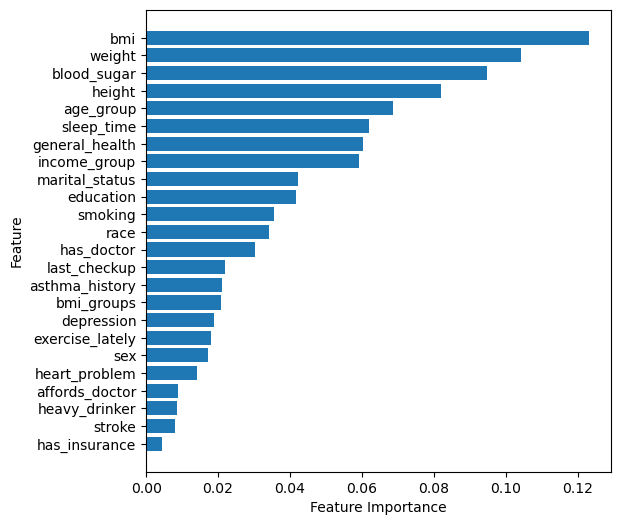

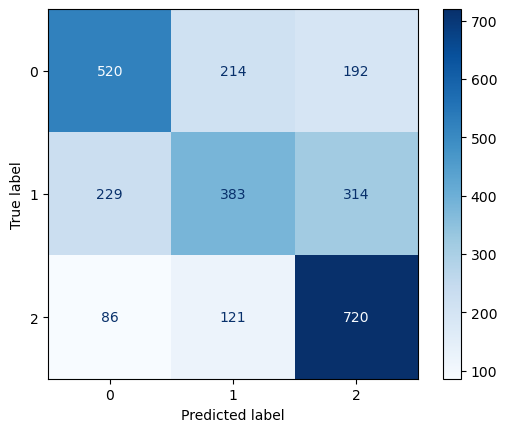

In [14]:
print('Implementing random forest on dataset without resampling...')
rf1 = random_forest(without_resampling.data, without_resampling.labels)
training_pipeline(rf1, report=True, fi=True, cm=True)

print('Implementing random forest on dataset with resampling...')
rf2 = random_forest(with_resampling.data, with_resampling.labels)
training_pipeline(rf2, report=True, fi=True, cm=True)

print('Implementing random forest on dataset with equalized labels...')
rf3 = random_forest(equalized.data, equalized.labels)
training_pipeline(rf3, report=True, fi=True, cm=True)

## XGBoost implementation

In [ ]:
print('Implementing XGBoost on dataset without resampling...')
xgb1 = xgb(without_resampling.data, without_resampling.labels)
training_pipeline(xgb1, report=True, fi=True, cm=True)

print('Implementing XGBoost on dataset with resampling...')
xgb2 = xgb(with_resampling.data, with_resampling.labels)
training_pipeline(xgb2, report=True, fi=True, cm=True)

print('Implementing XGBoost on dataset with equalized labels...')
xgb3 = xgb(equalized.data, equalized.labels)
training_pipeline(xgb3, report=True, fi=True, cm=True)

## Logistic Regression Implementation 

In [ ]:
print('Implementing logistic regression on dataset without resampling...')
lr1 = logistic_regression(without_resampling.data, without_resampling.labels)
training_pipeline(lr1, report=True, fi=False, cm=True)

print('Implementing logistic regression on dataset without resampling...')
lr2 = logistic_regression(with_resampling.data, with_resampling.labels)
training_pipeline(lr2, report=True, fi=False, cm=True)

print('Implementing logistic regression on dataset with equalized labels...')
lr3 = logistic_regression(equalized.data, equalized.labels)
training_pipeline(lr3, report=True, fi=False, cm=True)